In [4]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib 
# 터미널 입력시, '!'제외하고 입력

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.4.1


In [1]:
# 관련 라이브러리 설치
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

In [2]:
# SavedModel 로드
saved_model_dir = 'movenet_thunder_model'  # saved_model.pb 파일과 variables 폴더가 있는 디렉토리
model = tf.saved_model.load(saved_model_dir)

# TFLite 변환기 초기화
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# 최적화 옵션 설정 (선택사항)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 모델 변환
tflite_model = converter.convert()

# 변환된 모델 저장
tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite 모델이 {tflite_model_path}에 저장되었습니다.")


TensorFlow Lite 모델이 model.tflite에 저장되었습니다.


In [3]:
# 모델 불러오기
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

In [4]:
# 신체 부위 이름을 인덱스로 매핑하는 사전

KEYPOINT_DICT = {
    'nose': 0,  # 코
    'left_eye': 1,  # 왼쪽 눈
    'right_eye': 2,  # 오른쪽 눈
    'left_ear': 3,  # 왼쪽 귀
    'right_ear': 4,  # 오른쪽 귀
    'left_shoulder': 5,  # 왼쪽 어깨
    'right_shoulder': 6,  # 오른쪽 어깨
    'left_elbow': 7,  # 왼쪽 팔꿈치
    'right_elbow': 8,  # 오른쪽 팔꿈치
    'left_wrist': 9,  # 왼쪽 손목
    'right_wrist': 10,  # 오른쪽 손목
    'left_hip': 11,  # 왼쪽 엉덩이
    'right_hip': 12,  # 오른쪽 엉덩이
    'left_knee': 13,  # 왼쪽 무릎
    'right_knee': 14,  # 오른쪽 무릎
    'left_ankle': 15,  # 왼쪽 발목
    'right_ankle': 16  # 오른쪽 발목
}


# 신체 부위를 연결하는 선에 대해 Matplotlib 색상을 지정하는 사전


KEYPOINT_EDGES = {
    (0, 1): 'm',  # 코와 왼쪽 눈 연결
    (0, 2): 'c',  # 코와 오른쪽 눈 연결
    (1, 3): 'm',  # 왼쪽 눈과 왼쪽 귀 연결
    (2, 4): 'c',  # 오른쪽 눈과 오른쪽 귀 연결
    (0, 5): 'm',  # 코와 왼쪽 어깨 연결
    (0, 6): 'c',  # 코와 오른쪽 어깨 연결
    (5, 7): 'm',  # 왼쪽 어깨와 왼쪽 팔꿈치 연결
    (7, 9): 'm',  # 왼쪽 팔꿈치와 왼쪽 손목 연결
    (6, 8): 'c',  # 오른쪽 어깨와 오른쪽 팔꿈치 연결
    (8, 10): 'c',  # 오른쪽 팔꿈치와 오른쪽 손목 연결
    (5, 6): 'y',  # 왼쪽 어깨와 오른쪽 어깨 연결
    (5, 11): 'm',  # 왼쪽 어깨와 왼쪽 엉덩이 연결
    (6, 12): 'c',  # 오른쪽 어깨와 오른쪽 엉덩이 연결
    (11, 12): 'y',  # 왼쪽 엉덩이와 오른쪽 엉덩이 연결
    (11, 13): 'm',  # 왼쪽 엉덩이와 왼쪽 무릎 연결
    (13, 15): 'm',  # 왼쪽 무릎과 왼쪽 발목 연결
    (12, 14): 'c',  # 오른쪽 엉덩이와 오른쪽 무릎 연결
    (14, 16): 'c'  # 오른쪽 무릎과 오른쪽 발목 연결
}

In [5]:
# 비디오 캡쳐 시작
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
    
# 이미지 크기 조정 및 패딩
img = frame.copy()
img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 256,256)

In [6]:
# 키포인트 그리기 함수 
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

In [7]:
# 연결 관계 그리기 함수 정의
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

[[[[0.7205279  0.488773   0.5616058 ]
   [0.6749187  0.5333884  0.60085416]
   [0.6772816  0.43833518 0.576077  ]
   [0.7216944  0.5782136  0.48255974]
   [0.728025   0.3678074  0.3786306 ]
   [0.8340966  0.63144225 0.15925659]
   [0.8091555  0.33324945 0.16225195]
   [0.8650511  0.65708876 0.06077466]
   [0.6141495  0.22747089 0.03760336]
   [0.8481913  0.50418615 0.02364697]
   [0.61169106 0.29057258 0.10711318]
   [0.6279856  0.6136686  0.07447692]
   [0.8824159  0.31298247 0.02710883]
   [0.71900004 0.65762585 0.12910397]
   [0.627221   0.6358181  0.09478589]
   [0.61234087 0.6682043  0.10600132]
   [0.64340943 0.6551505  0.09201714]]]]
[[[[0.7234401  0.48779657 0.5689349 ]
   [0.6728179  0.534626   0.6104591 ]
   [0.6750463  0.4344873  0.660961  ]
   [0.7168333  0.5807996  0.42948323]
   [0.72860426 0.3642547  0.48211727]
   [0.84539056 0.62903035 0.16069596]
   [0.8111546  0.32147235 0.14278254]
   [0.86982936 0.6723014  0.07349296]
   [0.61612344 0.22809689 0.06283923]
   [0.859

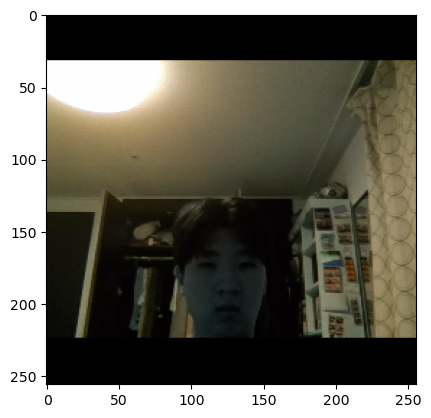

In [8]:
# 이미지 표시
plt.imshow(tf.cast(np.squeeze(img), dtype=tf.int32))

# 이미지 형태 확인
img = frame.copy()
img.shape

# 출력 디테일 확인
interpreter.get_output_details()

# 비디오 캡쳐 시작
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # 이미지 크기 조정 및 패딩
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 256,256)
    input_image = tf.cast(img, dtype=tf.int32)
    
    # 입력 및 출력 설정
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # 예측 수행
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    print(keypoints_with_scores)
    
    # 렌더링
    draw_connections(frame, keypoints_with_scores, KEYPOINT_EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)
    
    cv2.imshow('MoveNet Lightning', frame)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):       # 키보드 "q" 누르면 종료됨
        break
        
cap.release()
cv2.destroyAllWindows()

# 오른쪽 눈과 왼쪽 팔꿈치의 위치 확인
right_eye = keypoints_with_scores[0][0][2]
left_elbow = keypoints_with_scores[0][0][7]

# 형태 변경 후 키포인트 출력
shaped = np.squeeze(np.multiply(interpreter.get_tensor(interpreter.get_output_details()[0]['index']), [480,640,1]))
for kp in shaped:
    ky, kx, kp_conf = kp
    print(int(ky), int(kx), kp_conf)

# 키포인트 그리기 함수 
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 


# 키포인트와 연결 관계 출력
shaped[0], shaped[1]


# 연결 관계 그리기
for edge, color in KEYPOINT_EDGES.items():
    p1, p2 = edge
    y1, x1, c1 = shaped[p1]
    y2, x2, c2 = shaped[p2]
    print((int(x2), int(y2)))